#### Environment

In [ ]:
# install stuff
! pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub langchain langgraph

In [6]:
# load environment
from dotenv import load_dotenv
import os

if os.path.exists('ws.env'):
    load_dotenv('ws.env', override=True)

    # Models
    #LLM = 'gpt-4o'
    LLM = 'gpt3.5-turbo'
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

    # LangSmith tracing
    LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

#### Database

In [2]:
import sqlite3
import os

# Path to the cloned repository
repo_path = '../sf-legistar-scraper/data'

# Path to the SQLite database file
db_path = os.path.join(repo_path, 'legislation.db')

# Connect to the SQLite database
connection = sqlite3.connect(db_path)

# Create a cursor object
cursor = connection.cursor()

# Execute a query
cursor.execute('SELECT * FROM legislation LIMIT 1')

# Fetch all results
results = cursor.fetchall()

print(results)

[(1, '150155', 'Ordinance', '2/10/2015', '', '3/27/2015', 'General Plan - Repealing Ordinance No. 97-14 - Adoption of 2014 Housing Element', 'Passed', 'Clerk of the Board', '3/27/2015', '034-15', 'Ordinance amending the San Francisco General Plan by repealing the 2009 Housing Element (Ordinance No. 97-14), and adopting the 2014 Housing Element; and making findings, including environmental findings, and findings of consistency with the General Plan, and the eight priority policies of Planning Code, Section 101.1.', 'Mayor, Scott Wiener, Malia Cohen', '', 'https://sfgov.legistar.com/LegislationDetail.aspx?ID=3061931&GUID=57150071-5B0B-4F92-BA7B-CFC8E520598C&Options=Advanced&Search=')]


In [7]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///../sf-legistar-scraper/data/legislation.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM legislation LIMIT 1;")

sqlite
['history', 'legislation']


"[(1, '150155', 'Ordinance', '2/10/2015', '', '3/27/2015', 'General Plan - Repealing Ordinance No. 97-14 - Adoption of 2014 Housing Element', 'Passed', 'Clerk of the Board', '3/27/2015', '034-15', 'Ordinance amending the San Francisco General Plan by repealing the 2009 Housing Element (Ordinance No. 97-14), and adopting the 2014 Housing Element; and making findings, including environmental findings, and findings of consistency with the General Plan, and the eight priority policies of...', 'Mayor, Scott Wiener, Malia Cohen', '', 'https://sfgov.legistar.com/LegislationDetail.aspx?ID=3061931&GUID=57150071-5B0B-4F92-BA7B-CFC8E520598C&Options=Advanced&Search=')]"

#### Index
My index is just going to be embeddings of the ordinance titles so skip for now

In [ ]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

#### Tools

In [9]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langchain_core.pydantic_v1 import BaseModel, Field

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

# List tables tool
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
print("[list_tables_tool]")
print(list_tables_tool.invoke(""))

# Get schema tool
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
print("[get_schema_tool]")
print(get_schema_tool.invoke("legislation"))

# DB query tool
@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    print("TOOL: db_query_tool")
    print(f"-- query: {query}")
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result
print("[db_query_tool]")
print(db_query_tool.invoke("SELECT * FROM legislation LIMIT 1;"))

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    print("TOOL: SubmiteFinalAnswer")
    final_answer: str = Field(..., description="The final answer to the user")

[list_tables_tool]
history, legislation
[get_schema_tool]

CREATE TABLE legislation (
	id INTEGER, 
	file_number TEXT, 
	type TEXT, 
	introduced TEXT, 
	on_agenda TEXT, 
	enactment_date TEXT, 
	name TEXT, 
	status TEXT, 
	in_control TEXT, 
	final_action TEXT, 
	enactment_number TEXT, 
	title TEXT, 
	sponsors TEXT, 
	related_files TEXT, 
	url TEXT, 
	PRIMARY KEY (id)
)

/*
3 rows from legislation table:
id	file_number	type	introduced	on_agenda	enactment_date	name	status	in_control	final_action	enactment_number	title	sponsors	related_files	url
1	150155	Ordinance	2/10/2015		3/27/2015	General Plan - Repealing Ordinance No. 97-14 - Adoption of 2014 Housing Element	Passed	Clerk of the Board	3/27/2015	034-15	Ordinance amending the San Francisco General Plan by repealing the 2009 Housing Element (Ordinance N	Mayor, Scott Wiener, Malia Cohen		https://sfgov.legistar.com/LegislationDetail.aspx?ID=3061931&GUID=57150071-5B0B-4F92-BA7B-CFC8E52059
2	151119	Ordinance	12/15/2015	1/26/2016	3/11/2016	Est

##### Utilities

In [10]:
# not really sure why these are necessary
# what would happen if we don't catch error?

from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    print("f: create_tool_node_with_fallback ({tools})")
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    print("NODE?f?: handle_tool_error")
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [32]:
# quasi tool
from langchain_core.prompts import ChatPromptTemplate

# query check system
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins
- Note that dates are given in the form MM/DD/YYYY

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

#################################
# query gen system
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)

#### LLMs

In [33]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "SQL_database"] = Field(
        ...,
        description="Given a user question choose to route it to a vectorstore or a SQL database.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """
You are an expert at routing a user legal question to a vectorstore or SQL database.
The laws are ordinances passed in San Francisco in 2023.

The SQL database has the following schema:
- Table `legislation`:
  - Columns: id, file_number, type, introduced, on_agenda, enactment_date, name, status, in_control, final_action, enactment_number, title, sponsors, related_files, url
- Table `history`:
  - Columns: id, legislation_id, date, ver, action_by, action, result

Here are example ordinances:
[ordinance1]
file_number=231142
type=Ordinance
introduced=10/30/2023	
on_agenda=
enactment_date=
name=Planning Code - Housing Production
status=Killed
in_control=Land Use and Transportation Committee
final_action=12/5/2023
enactment_number=
title=Ordinance amending the Planning Code to encourage housing production by 1) exempting, under certain conditions, specified housing projects from the Conditional Use requirement of Section 317, in areas outside of Priority Equity Geographies, which are identified in the Housing Element as areas or neighborhoods with a high density of vulnerable populations 2) restoring the ownership eligibility requirement for density exceptions in residential districts, for lots that have two existing dwelling units or more; 3) sunsetting the Conditional Use requirements established by the Corona Heights Large Residence and the Central Neighborhoods Large Residence Special Use Districts at the end of 2024, and thereafter limiting the size of any Dwelling Units resulting from residential development in those Special Use Districts to 3,000 square feet of Gross Floor Area; affirming the Planning Department’s determination under the California Environmental Quality Act; and making public necessity, convenience, and welfare findings under Planning Code, Section 302, and findings of consistency with the General Plan and the eight priority policies of Planning Code, Section 101.1.
sponsors=Mayor, Joel Engardio
related_files=231258, 230446, 231219
url=
[/ordinance1]

[ordinance2]
file_number=230853
type=Ordinance
introduced=7/25/2023
on_agenda=
enactment_date=11/3/2023
name=Park Code - John F. Shelley Drive - Road Closure
status=Passed
in_control=Clerk of the Board
final_action=11/3/2023
enactment_number=222-23
title=Ordinance amending the Park Code to restrict private vehicles from a portion of John F. Shelley Drive, between the Upper Reservoir Parking Lot and Mansell Street, in McLaren Park.
sponsors=Mayor, Shamann Walton, Myrna Melgar, Dean Preston, Hillary Ronen, Ahsha Safai
related_files=
url=
[/ordinance2]

The vectorstore contains ordinance titles which describe what the ordinance does.

Use the following guidelines to route the query:
1. Route to SQL Database for factual questions that can be directly answered from the database schema.
   - Example: "Who sponsored the most legislation in 2023?"
   - Example: "When was Ordinance XYZ enacted?"

2. Route to Vectorstore for questions that require understanding the context or details from the ordinance titles.
   - Example: "Which laws changed housing policy?"
   - Example: "What ordinances were introduced to improve public transportation?"

Given the user question, determine the most relevant datasource.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

# print(question_router.invoke({"question": "Who was the primary sponsor on the most legislation in 2023?"}))
# print(question_router.invoke({"question": "Which laws changed housing policy?"}))
# print(question_router.invoke({"question": "How many laws affected housing policy?"}))
# print(question_router.invoke({"question": "Who introduced the most legislation?"}))
# print(question_router.invoke({"question": "Who missed the most votes?"}))
# print(question_router.invoke({"question": "How long does law take to pass on average?"}))
# print(question_router.invoke({"question": "How many ordinances failed to pass?"}))
# print(question_router.invoke({"question": "How often is the Police Code changed?"}))

#### Graph

##### Graph State

In [34]:
from typing import Annotated, Literal

from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

##### Graph Flow

In [36]:
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langchain.schema import Document


### NODES ###

# Add a node for the first tool call
# note: dumb and only necessary because the dumb tool expects an AIMessage
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    print("NODE: first_tool_call")
    print(f"-- state: {state}")
    print(f"-- message: {state['messages']}")
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    print("NODE: model_check_query")
    print(f"-- state: {state}")
    print(f"-- message: {state['messages']}")
    """
    Use this tool to double-check if your query is correct before executing it.
    """

    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

# generate a query based on the question and schema
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    print("NODE: query_gen_node")
    print(f"-- state: {state}")
    #print(f"-- message: {state['messages']}")
    print(f"-- message: {message}")
    print(f"-- message.tool_calls: {message.tool_calls}")

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

def vectorstore_stub(state: State):
    print("[NODE] vectorstore_stub")
    return {"messages": "vectorstore_stub all done"}

### Edges ###

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["messages"]
    source = question_router.invoke({"question": question})
    if source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO vectorstore---")
        return "vectorstore"
    elif source.datasource == "SQL_database":
        print("---ROUTE QUESTION TO SQL DB---")
        return "SQL_database"

##### Build Graph

In [37]:
from typing import Annotated, Literal

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(State)

### NODES ###

# Add list_tables node
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)

# Add get_schema node
workflow.add_node(
    "get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([get_schema_tool])

workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

# Add dumb first tool call node
workflow.add_node("first_tool_call", first_tool_call)

# Add a node for a model to generate a query based on the question and schema
workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Add a stub node for the vectorstore pathway
workflow.add_node("vectorstore_stub", vectorstore_stub)

### EDGES ###

workflow.set_conditional_entry_point(
    route_question,
    {
        "vectorstore": "vectorstore_stub",
        "SQL_database": "first_tool_call",
    },
)

# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    print("NODE: should_continue")
    print(f"-- state: {state}")
    print(f"-- message: {state['messages']}")
    #print(f"-- message: {message}")
    #print(f"-- message.tool_calls: {message.tool_calls}")
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"
    
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

workflow.add_edge("vectorstore_stub", END)

# Compile the workflow into a runnable
app = workflow.compile()

f: create_tool_node_with_fallback ({tools})
f: create_tool_node_with_fallback ({tools})
f: create_tool_node_with_fallback ({tools})


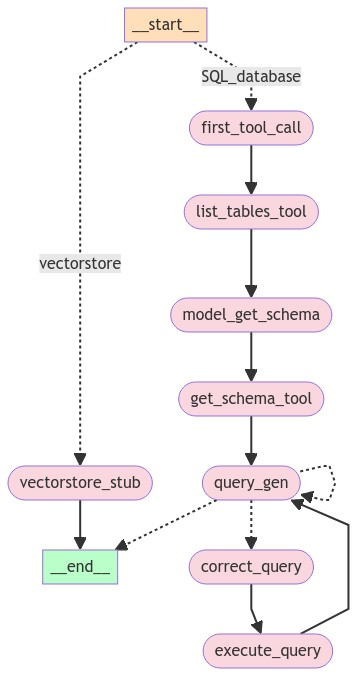

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [42]:
import json

#query = "Which supervisors introduced ordinances in 2023?"
#query = "How many ordinances were introduced in 2023?"

#query = "Who sponsored ordinance file number 230806"
# answer: 'The ordinance file number 230806 does not have any sponsors listed.' (this is right)

#query = "Who sponsored ordinance file number 230795"
# answer: hit recursion limit even tho answer should have been "no sponsors" like above

query = "Who sponsored ordinance file number 230761"
# answer: 'The sponsor of ordinance file number 230761 is the Mayor.' (this is right)


messages = app.invoke(
    {"messages": [("user", query)]}
)
json_str = messages["messages"][-1].additional_kwargs["tool_calls"][0]["function"][
    "arguments"
]
json.loads(json_str)["final_answer"]

---ROUTE QUESTION---
---ROUTE QUESTION TO SQL DB---
NODE: first_tool_call
-- state: {'messages': [HumanMessage(content='Who sponsored ordinance file number 230761', id='db130899-d459-4464-b13e-c306df824943')]}
-- message: [HumanMessage(content='Who sponsored ordinance file number 230761', id='db130899-d459-4464-b13e-c306df824943')]
NODE: query_gen_node
-- state: {'messages': [HumanMessage(content='Who sponsored ordinance file number 230761', id='db130899-d459-4464-b13e-c306df824943'), AIMessage(content='', id='4360ee3e-4d16-4013-9aae-8b409c865c89', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123'}]), ToolMessage(content='history, legislation', name='sql_db_list_tables', id='3f7ada54-3269-4331-a3f8-4081a062f649', tool_call_id='tool_abcd123'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pwsa4OPwGMeqPnxcDjyzGmVd', 'function': {'arguments': '{"table_names":"legislation"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata

'The sponsor of ordinance file number 230761 is the Mayor.'